In [1]:
import os, glob, shutil, sys, copy, time, json, copy, subprocess
from IPython import display
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, color, transform, exposure
from skimage.filters import threshold_mean
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows, crop
import imagej
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
import warnings

from acquisitions import *
from image_utils import *

In [2]:
# os.environ['JAVA_MEM'] = '-Xmx4096m'
os.environ['_JAVA_OPTIONS']="-Xmx8g"
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None        

In [3]:
config = {
    "pixel-size-bf-20x" : 0.252, # 0.508
    "pixel-size-bf-4x" : 1.26, # micron/pixel
    "pixel-size-shg" : 0.42,
    "camera-resolution" : (1392, 1040), # (width, height)
#    "camera-resolution" : (512, 512), # (width, height)
    "lsm-resolution-base" : (256, 256),  
    "slide-size" : (38000.0, 18000.0), # (width, height) (70000, -20000)
#    "slide-size" : (4000, 2000), # (width, height) (70000, -20000)
    "slide-start" : (0, 0), # x, y
    "Z-stage-20x" : -7460,
    "Z-stage-laser" : -6610, #-5550
    "Z-stage-4x" : -900,
    "F-stage-20x" : -15000, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : 3000,
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-2000.0, 40000.0),
    "hard-limit-y" : (-2000, 20000.0),
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (0, 0), # point to 4x bf
    "shg-offset" : (0, 0), # point to 4x bf
    "lsm-resolution" : 256,
    "lsm-bin-factor" : 3,
    "lsm-scan-rate" : '625000.0000',
    "lsm-pc-power" : 0.4, # 1
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}
# 4x position list is in row x column x z, 20x and shg position lists are in pos x z, order is x, y

In [4]:
def resample_z_pos(config, mag='20x', mod='bf', xy_pos=None, xyz_pos_list_4x=None):
    xy_pos_list = xyz_pos_list_4x[:, :, :2] # x, y, z
    z_pos_list = xyz_pos_list_4x[:, :, 2]
#     list_w = xyz_pos_list[-1, -1, 0] - xyz_pos_list[0, 0, 0] # first pos, width
#     list_h = xyz_pos_list[-1, -1, 1] - xyz_pos_list[0, 0, 1] # last pos, height
#     resample_w = int(np.rint(list_w / 50))
#     resample_h = int(np.rint(list_h / 50))
    list_w = xyz_pos_list_4x.shape[0]
    list_h = xyz_pos_list_4x.shape[1]
    dense_xy = transform.resize(xy_pos_list, (list_w*50, resample_w*50), order=1)
    dense_z = transform.resize(z_pos_list, (list_w*50, resample_w*50), order=3)
    dense_xyz = np.concatenate((dense_xy, dense_z[:, :, None]), axis=2)
    xyz_list = np.ones((xy_pos.shape[0], 3))
    for i in range(xy_pos.shape[0]):
        x_pos = xy_pos[i, 0]
        y_pos = xy_pos[i, 1]
        x_idx = np.abs(dense_xyz[0, :, 0] - x_pos).argmin()
        y_idx = np.abs(dense_xyz[:, 0, 1] - y_pos).argmin()
        if mag=='20x':
            z_offset = config["Z-stage-20x"] - config["Z-stage-4x"]
        if mod=='shg':
            z_offset = config["Z-stage-laser"] - config["Z-stage-4x"]
        z_pos = dense_xyz[x_idx, y_idx, 2] + z_offset
        xyz_list[i] = [x_pos, y_pos, z_pos]
    return xyz_list # x, y, z
    

def generate_grid(config, mag='4x', mod='bf', box=None, overlap=50, xyz_pos_list=None, z_offset=0):
    if box is not None:
        s_x = box[0]
        s_y = box[1]
        e_x = box[2]
        e_y = box[3]
    else:
        s_x = config["slide-start"][0]
        s_y = config["slide-start"][1]
        e_x = config["slide-start"][0] + config["slide-size"][0]
        e_y = config["slide-start"][1] + config["slide-size"][1]
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        field_w = config["camera-resolution"][0] * pixel_size
        field_h = config["camera-resolution"][1] * pixel_size
    if mod == 'shg':
        if mag == '20x':
            pixel_size = config["pixel-size-shg"]
        if mag == '4x':
            raise ValueError('Not supported magnification for LSM')
        field_w = config["lsm-resolution-base"][0] * pixel_size
        field_h = config["lsm-resolution-base"][1] * pixel_size
    field_o = overlap * pixel_size
    grid_w = int(np.ceil((e_x - s_x) / (field_w - field_o)))
    grid_h = int(np.ceil((e_y - s_y) / (field_h - field_o)))
    if xyz_pos_list is not None:
        xy_pos_list = xyz_pos_list[:, :, :2] # x, y, z
        z_pos_list = xyz_pos_list[:, :, 2]
        list_w = xyz_pos_list[-1, -1, 0] - xyz_pos_list[0, 0, 0] # first pos
        list_h = xyz_pos_list[-1, -1, 1] - xyz_pos_list[0, 0, 1] # last pos
        resample_w = int(np.rint(list_w / 50))
        resample_h = int(np.rint(list_h / 50))
        dense_xy = transform.resize(xy_pos_list, (resample_h, resample_w), order=1)
        dense_z = transform.resize(z_pos_list, (resample_h, resample_w), order=3)
        dense_xyz = np.concatenate((dense_xy, dense_z[:, :, None]), axis=2)
        xy_list = np.zeros((grid_h, grid_w, 3))
    else:
        xy_list = np.zeros((grid_h, grid_w, 2))
    for x in range(grid_w):
        for y in range(grid_h):
            x_pos = x * (field_w - field_o) + s_x
            y_pos = y * (field_h - field_o) + s_y
            if xyz_pos_list is not None:
                x_idx = np.abs(dense_xyz[0, :, 0] - x_pos).argmin()
                y_idx = np.abs(dense_xyz[:, 0, 1] - y_pos).argmin()
                z_pos = dense_xyz[x_idx, y_idx, 2] + z_offset
                xy_list[y, x] = [x_pos, y_pos, z_pos]
            else:
                xy_list[y, x] = [x_pos, y_pos] # x, y
    return xy_list, (grid_h, grid_w) # row, col

def whole_slide_scan(config, core=None, save_path=None, acq_name=None, position_list=None, mda=False, z_stack=False, z_center=None, sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if position_list.shape[1] == 3:
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        if position_list.shape[1] == 3:
            tile_count = 0
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            core.set_focus_device(config["focus-device"])                
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2).reshape(position_list.shape[0], 3)
#             position_list = position_list.reshape(position_list.shape[0]*position_list.shape[1], position_list.shape[2])
            for pos in range(position_list.shape[0]):
                z_pos = position_list[pos, 2]
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                    or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                    print('position out of range')
                    break
                core.set_position(z_pos)
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.wait_for_device(xy_device)
                core.wait_for_device(z_device)
                if focus_dive == True:
                    pos_z, pixels = autofocus(core, method='entropy', rgb=True, search_range=100, crop_ratio=1.0, flip_channel=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    print('background')
                    if is_background(pixels):
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                if background_image is not None:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
                    
        if position_list.shape[1] == 2:
            tile_count = 0
#             core.set_focus_device(config["focus-device"])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
#             position_list = position_list.reshape(position_list.shape[0], position_list.shape[1], 2)
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                    print('position out of range')
                    break
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                core.wait_for_device(xy_device)
                if focus_dive == True:
                    pos_z, pixels = autofocus(core, method='entropy', rgb=True, search_range=100, crop_ratio=1.0, flip_channel=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if is_background(pixels):
                        print(' (background tile)')
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                if background_image is not None:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            returns.append((sum_img / sum_count))
            io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(np.squeeze(sum_img / sum_count)))
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], position_list.shape[1])
            returns.append(z_positions)
        return tuple(returns)

In [5]:
def autofocus(core, method='entropy', rgb=True, search_range=45, crop_ratio=1.0, flip_channel=True):
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = int(search_range/9)
    scores = []
    positions = []
    count = 0
    for step in range(-4, 4):
        position_z = step * interval_z + current_z
        if position_z < -3000.0 or position_z > 22000.0:
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if is_background(pixels):
            return current_z, pixels
        img_gray = color.rgb2gray(pixels)
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions)
    
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    core.set_position(position_z)
    pixels = snap_image(core, rgb=rgb, flip_channel=True)
    return focus_z, pixels

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        core.wait_for_system()
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        core.wait_for_system()
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    return position_list_z

In [6]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()

In [7]:
core.set_timeout_ms(20000)

In [11]:
switch_objective(config, '20x')

In [12]:
switch_mod(config, mod='bf')

Imaging mode set as Brightfield


array([[6537, 6743, 6415, ..., 6642, 6448, 6595],
       [6371, 6559, 6332, ..., 6769, 6435, 6820],
       [6629, 6714, 6537, ..., 6752, 6759, 6398],
       ...,
       [6548, 6520, 6395, ..., 6447, 6401, 6438],
       [6589, 6342, 6897, ..., 6409, 6826, 6417],
       [6782, 6539, 6292, ..., 6592, 6331, 6430]], dtype=uint16)

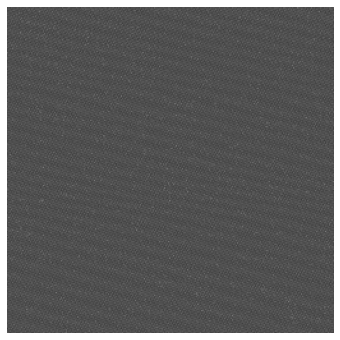

In [19]:
live(core, mod='shg')

In [10]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-test'

In [11]:
# position_list, grid = generate_grid(config, mag='4x', box=(5000, 5000, 20000, 15000))
position_list, grid = generate_grid(config, mag='4x')
position_list.shape

(15, 23, 2)

In [12]:
position_list

array([[[    0.  ,     0.  ],
        [ 1690.92,     0.  ],
        [ 3381.84,     0.  ],
        [ 5072.76,     0.  ],
        [ 6763.68,     0.  ],
        [ 8454.6 ,     0.  ],
        [10145.52,     0.  ],
        [11836.44,     0.  ],
        [13527.36,     0.  ],
        [15218.28,     0.  ],
        [16909.2 ,     0.  ],
        [18600.12,     0.  ],
        [20291.04,     0.  ],
        [21981.96,     0.  ],
        [23672.88,     0.  ],
        [25363.8 ,     0.  ],
        [27054.72,     0.  ],
        [28745.64,     0.  ],
        [30436.56,     0.  ],
        [32127.48,     0.  ],
        [33818.4 ,     0.  ],
        [35509.32,     0.  ],
        [37200.24,     0.  ]],

       [[    0.  ,  1247.4 ],
        [ 1690.92,  1247.4 ],
        [ 3381.84,  1247.4 ],
        [ 5072.76,  1247.4 ],
        [ 6763.68,  1247.4 ],
        [ 8454.6 ,  1247.4 ],
        [10145.52,  1247.4 ],
        [11836.44,  1247.4 ],
        [13527.36,  1247.4 ],
        [15218.28,  1247.4 ],
        

 345/690 tiles done

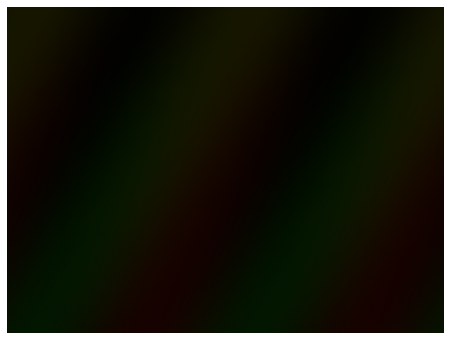

In [19]:
bg_img = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=False, estimate_background=False, focus_dive=False)

In [17]:
bg_img = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=True, estimate_background=False, focus_dive=False)

 345/345 tiles done

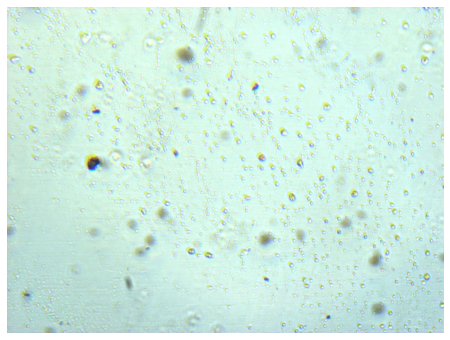

In [16]:
bg_img = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list, mda=False, estimate_background=True, focus_dive=False)
bg_img = bg_img[0]

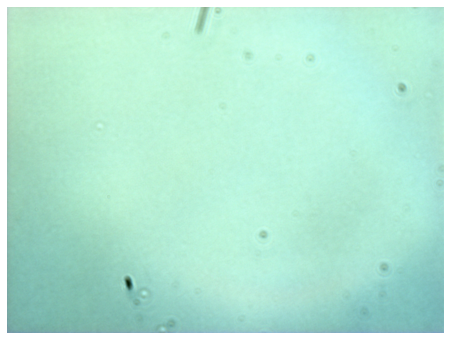

In [17]:
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(bg_img, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [8]:
ij = imagej.init('fiji\\fiji\\Fiji.app')

In [13]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=False)

stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-sample-test\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (1455 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-sample-test\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (51 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scan

In [12]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=True, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=False)

Dataset opened of 1
stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-sample-test\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (820 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-sample-test\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (53 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scann

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data/stitching/stitched\\slide-sample-test\\fused.tiff' -> 'data/slides\\slide-sample-test.tiff'

In [19]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_img)

stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-test\0_23.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (784 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-test\0_22.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (120 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Load

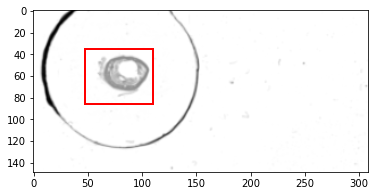

In [32]:
img = io.imread(os.path.join('data', 'stitching', 'stitched', acq_name, 'fused.tiff'))
bounding_box_4x = bounding_image(config, img, box=(6000, 4500, 14000, 11000))

In [33]:
bounding_box_4x

(6000, 4500, 14000, 11000)

In [34]:
position_list, grid = generate_grid(config, mag='20x', box=bounding_box_4x)
position_list.shape

(27, 25, 2)

In [35]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-test-box-20x'

 675/675 tiles done

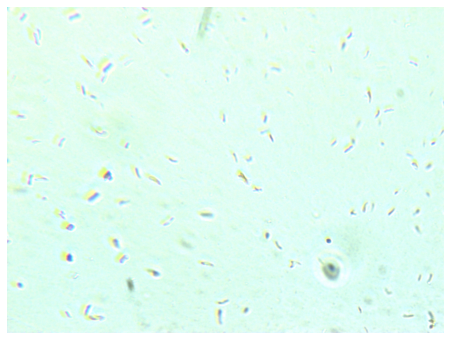

In [37]:
switch_objective(config, '20x')
bg_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list, mda=False, estimate_background=True, focus_dive=False)

In [38]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_20x[0])

stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-test-box-20x\0_25.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (200 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-test-box-20x\0_24.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (175 ms)[java.lang.Enum.toString] 
[java.lang.Enu

In [97]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=True, z_stack=True, position_list=position_list, flip_y=True, correction=True)

Dataset opened of 1
stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_10.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_10.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 512x512x6px, channels=1, timepoints=1 (62 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\sm

In [26]:
Image.MAX_IMAGE_PIXELS = None        
img = io.imread('example/BIC14011b.jpg')

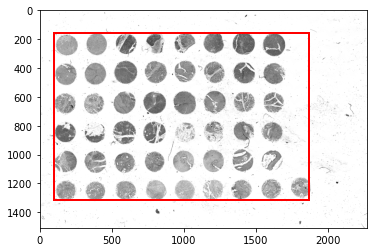

(2250.0, 3555.0, 42007.5, 29632.5)

In [67]:
bounding_box_4x = bounding_image(config, img)

In [85]:
autofocus(core, search_range=90)

4929
17.64436457496112
4939
17.65342005021535
4949
17.661655348030425
4959
17.668416834855833
4969
17.674633440854986
4979
17.67761608605648
4989
17.67937351747418
4999
17.67871046983665
72


4992.797468354431

In [41]:
def annotations_positionlist(config, image_name, mod='bf', mag='4x', box=(0, 0, 0, 0)):
    pos_lists = []
    annotations = glob.glob(os.path.join('annotations', image_name, '*.csv'))
    for annotation in annotations:
        df = pd.read_csv(annotation)
        pos_list = np.array(df)
        pos_list[:, 0] = pos_list[:, 0] + box[0]
        pos_list[:, 1] = pos_list[:, 1] + box[1]
        pos_lists.append(pos_list)
    return pos_lists # list of (x_pos, y_pos) array

In [12]:
annotation_path = filedialog.askopenfilename(filetypes=(("Json annotation files","*.json"),("All files","*.*")))
coords = extract_rois(config, 'example/qupath-pj/annotation results/BIC14011b.jpg.json', image_size=(22689, 15080))

FileNotFoundError: [Errno 2] No such file or directory: 'example/qupath-pj/annotation results/BIC14011b.jpg.json'

In [141]:
bposition_list_z = focus_dive(core, position_list, search_range=18, resample_grid_size=(position_list_20x.shape[0], position_list_20x.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]


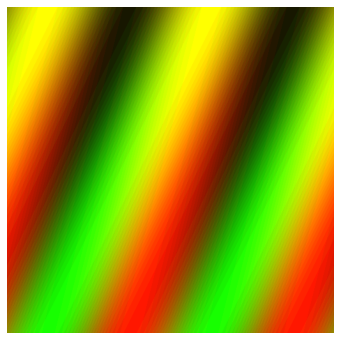

In [25]:
core.set_position(20)
core.wait_for_system()
core.snap_image()
tagged_image = core.get_tagged_image()
rgb = True
if rgb == True:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
        )
else:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
pixels = pixels[:, :, 0:3]
pixels=np.flip(pixels, 2)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [ ]:
### load libraries
bridge = Bridge()
core = bridge.get_core()
ij = imagej.init('fiji\\fiji\\Fiji.app')
Image.MAX_IMAGE_PIXELS = None  
core.set_timeout_ms(20000)

In [ ]:
### collect brightfield image
save_path = 'data/acquisition'
acq_name = 'slide-bf-test'
position_list, grid = generate_grid(config, mag='4x')
estimated_background_img = whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=False, core=core, estimate_background=True) # acquire 4x bf
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_img) # stitch 4x bf

In [1]:
import os, glob, subprocess
import pandas as pd
import numpy as np

In [7]:
script = os.path.join('qupath-scripts', 'export-ometif-metadata.groovy')
qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
image_dirs = glob.glob(os.path.join('data', 'slides', '*.tif'))
for img_dir in image_dirs:
    if img_dir.find("ome"):
        continue
    subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)
    os.remove(img_dir)

In [ ]:
def annotations_to_positions(config, image_type='4x'):
    if image_type == '4x':
        coords_csvs = glob.glob("qupath-projects/4x-tiles/*.csv")
    if image_type == '20x':
        off_set = config["20x-bf-offset"]
        coords_csvs = glob.glob("qupath-projects/20x-tiles/*.csv")
    if image_type == 'shg':
        off_set = config["shg-offset"]
        coords_csvs = glob.glob("qupath-projects/mp-tiles/*.csv")
    coords_list = []
    for coords_csv in coords_csvs:
        coords_df = pd.read_csv(coords_csv)
        coords_array = np.array(coords_df)
        coords_array[:, 0] = coords_array[:, 0] + offset[0]
        coords_array[:, 1] = coords_array[:, 1] + offset[1]
        coords_list.append(coords_array)
    return coords_list

In [9]:
coords_list

[array([[   0.,    0.],
        [   0.,  990.],
        [   0., 1980.],
        [   0., 2970.],
        [1270.,    0.],
        [1270.,  990.],
        [1270., 1980.],
        [1270., 2970.],
        [2540.,    0.],
        [2540.,  990.],
        [2540., 1980.],
        [2540., 2970.],
        [3810.,    0.],
        [3810.,  990.],
        [3810., 1980.],
        [3810., 2970.]])]

In [4]:
script = os.path.join('qupath-scripts', 'export-entire-image-as-patches.groovy')
qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
image_dirs = glob.glob(os.path.join('data', 'slides', '*.tif'))
for img_dir in image_dirs:
    subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)